In [1]:
# Import dependencies
# Database Dependencies
import pymongo
import gridfs
import pandas as pd
import io
import numpy as np
from PIL import Image, ImageOps
import subprocess
from config import DB_NAME, FEAT_3_COLLECTION_NAME, FEAT_30_COLLECTION_NAME
import json 

# Machine Learning Dependencies
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Neural Network Dependencies
import tensorflow as tf
from tensorflow import keras

# Database Connection and Loading Data

In [2]:
# Establish mongo instance and get Music database
client = pymongo.MongoClient('localhost')
db = client[DB_NAME]
db.list_collection_names()

['fs.files', 'feat_30', 'fs.chunks', 'feat_3']

In [3]:
# Select 'feat_3' collection, and read in as pandas DataFrame
collection = db[FEAT_3_COLLECTION_NAME].find()
features_3_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_3_df = features_3_df.drop(columns = ["_id"])
features_3_df

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0     blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
1     blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
2     blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
3     blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4     blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
...                 ...     ...               ...              ...       ...   
9985   rock.00099.5.wav   66149          0.349126         0.080515  0.050019   
9986   rock.00099.6.wav   66149          0.372564         0.082626  0.057897   
9987   rock.00099.7.wav   66149          0.347481         0.089019  0.052403   
9988   rock.00099.8.wav   66149          0.387527         0.084815  0.066430   
9989   rock.00099.9.wav   66149          0.369293         0.086759  0.050524   

       rms_var  spectral_centroid_mean  spectral_centroid_var  \
0     0.001450             1816.693777           90525.690866   
1     0.001701             1630.656199           79667.267654   
2     0.003521             1773.065032          167541.630869   
3     0.002448             1655.289045          111952.284517   
4     0.004620             1788.539719          111407.437613   
...        ...                     ...                    ...   
9985  0.000097             1499.083005          164266.886443   
9986  0.000088             1847.965128          281054.935973   
9987  0.000701             1346.157659          662956.246325   
9988  0.000320             2084.515327          203891.039161   
9989  0.000067             1634.330126          411429.169769   

      spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0                 2010.051501            65671.875673  ...   64.748276   
1                 1948.503884            60204.020268  ...   30.336359   
2                 1972.744388           117335.771563  ...   39.687145   
3                 1960.039988            82913.639269  ...   47.739452   
4                 2084.565132            75124.921716  ...   67.336563   
...                       ...                     ...  ...         ...   
9985              1718.707215            85931.574523  ...   42.485981   
9986              1906.468492            99727.037054  ...   32.415203   
9987              1561.859087           138762.841945  ...   78.228149   
9988              2018.366254            22860.992562  ...   28.323744   
9989              1867.422378           119722.211518  ...   38.801735   

      mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0       -6.055294   40.677654     0.159015   51.264091    -2.837699   
1        0.664582   45.880913     1.689446   51.363583    -3.392489   
2       -3.241280   36.488243     0.722209   38.099152    -5.050335   
3       -3.841155   28.337118     1.218588   34.770935    -3.580352   
4       -1.768610   28.348579     2.378768   45.717648    -1.938424   
...           ...         ...          ...         ...          ...   
9985    -9.094270   38.326839    -4.246976   31.049839    -5.625813   
9986   -12.375726   66.418587    -3.081278   54.414265   -11.960546   
9987    -2.524483   21.778994     4.809936   25.980829     1.775686   
9988    -5.363541   17.209942     6.462601   21.442928     2.354765   
9989   -11.598399   58.983097    -0.178517   55.761299    -6.903252   

      mfcc19_var  mfcc20_mean  mfcc20_var  label  
0      97.030830     5.784063   59.943081  blues  
1      26.738789     0.536961   29.146694  blues  
2      33.618073    -0.243027   43.771767  blues  
3      50.836224     3.630866   32.023678  blues  
4      53.050835     2.517375   33.105122  blues  
...          ...          ...         ...    ...  
9985   48.804092     1.818823   38.966969   rock  
9986   63.452255     0.428857   18.697033   rock  
9987   48.582378    -0.299545   41.586990   rock  
9988   24.843613     

In [4]:
# Select 'feat_30' collection, and read in as pandas DataFrame
collection = db[FEAT_30_COLLECTION_NAME].find()
features_30_df = pd.DataFrame(list(collection))

# Drop mongo generated hash-code id column
features_30_df = features_30_df.drop(columns = ["_id"])
features_30_df

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0    blues.00000.wav  661794          0.350088         0.088757  0.130228   
1    blues.00001.wav  661794          0.340914         0.094980  0.095948   
2    blues.00002.wav  661794          0.363637         0.085275  0.175570   
3    blues.00003.wav  661794          0.404785         0.093999  0.141093   
4    blues.00004.wav  661794          0.308526         0.087841  0.091529   
..               ...     ...               ...              ...       ...   
995   rock.00095.wav  661794          0.352063         0.080487  0.079486   
996   rock.00096.wav  661794          0.398687         0.075086  0.076458   
997   rock.00097.wav  661794          0.432142         0.075268  0.081651   
998   rock.00098.wav  661794          0.362485         0.091506  0.083860   
999   rock.00099.wav  661794          0.358401         0.085884  0.054454   

      rms_var  spectral_centroid_mean  spectral_centroid_var  \
0    0.002827             1784.165850          129774.064525   
1    0.002373             1530.176679          375850.073649   
2    0.002746             1552.811865          156467.643368   
3    0.006346             1070.106615          184355.942417   
4    0.002303             1835.004266          343399.939274   
..        ...                     ...                    ...   
995  0.000345             2008.149458          282174.689224   
996  0.000588             2006.843354          182114.709510   
997  0.000322             2077.526598          231657.968040   
998  0.001211             1398.699344          240318.731073   
999  0.000336             1609.795082          422203.216152   

     spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0                2002.449060            85882.761315  ...   52.420910   
1                2039.036516           213843.755497  ...   55.356403   
2                1747.702312            76254.192257  ...   40.598766   
3                1596.412872           166441.494769  ...   44.427753   
4                1748.172116            88445.209036  ...   86.099236   
..                       ...                     ...  ...         ...   
995              2106.541053            88609.749506  ...   45.050526   
996              2068.942009            82426.016726  ...   33.851742   
997              1927.293153            74717.124394  ...   33.597008   
998              1818.450280           109090.207161  ...   46.324894   
999              1797.213044           120115.632927  ...   59.167755   

     mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
0      -1.690215   36.524071    -0.408979   41.597103    -2.303523   
1      -0.731125   60.314529     0.295073   48.120598    -0.283518   
2      -7.729093   47.639427    -1.816407   52.382141    -3.439720   
3      -3.319597   50.206673     0.636965   37.319130    -0.619121   
4      -5.454034   75.269707    -0.916874   53.613918    -4.404827   
..           ...         ...          ...         ...          ...   
995   -13.289984   41.754955     2.484145   36.778877    -6.713265   
996   -10.848309   39.395096     1.881229   32.010040    -7.461491   
997   -12.845291   36.367264     3.440978   36.001110   -12.588070   
998    -4.416050   43.583942     1.556207   34.331261    -5.041897   
999    -7.069775   73.760391     0.028346   76.504326    -2.025783   

     mfcc19_var  mfcc20_mean  mfcc20_var  label  
0     55.062923     1.221291   46.936035  blues  
1     51.106190     0.531217   45.786282  blues  
2     46.639660    -2.231258   30.573025  blues  
3     37.259739    -3.407448   31.949339  blues  
4     62.910812   -11.703234   55.195160  blues  
..          ...          ...         ...    ...  
995   54.866825    -1.193787   49.950665   rock  
996   39.196327    -2.795338   31.773624   rock  
997   42.502201    -2.106337   29.865515   rock  
998   47.227180    -3.590644   41.299088   rock  
999   72.189316     1.155239   49.662510   rock  


In [5]:
cwd_bytes = subprocess.check_output("pwd")
cwd = cwd_bytes.decode("utf-8").rstrip("\n") + "/"

In [6]:
# identify path for images
images_path = "Data/images_original/"

In [7]:
byte_images = subprocess.check_output(["ls", cwd + images_path])
images_folder = byte_images.decode("utf-8").split("\n")
images_folder.pop(-1)

''

In [8]:
# Establish the gridfs instance
fs = gridfs.GridFS(db)

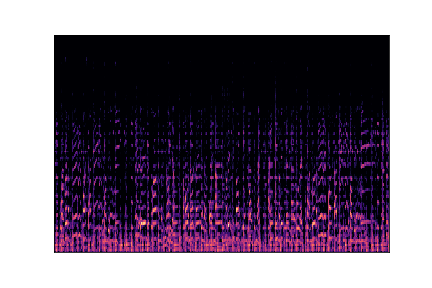

In [9]:
# Single Image Test
test_raw = fs.get_last_version("Data/images_original/blues/blues00000.png")
test_bytes = test_raw.read()
rgba_test = Image.open(io.BytesIO(test_bytes))
# RGBA Image (default)
rgba_test

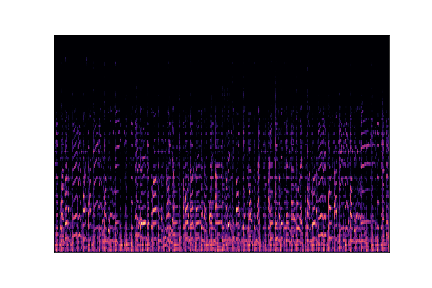

In [10]:
# Converting RGBA TO RGB
rgb_test = rgba_test.convert("RGB")
rgb_test

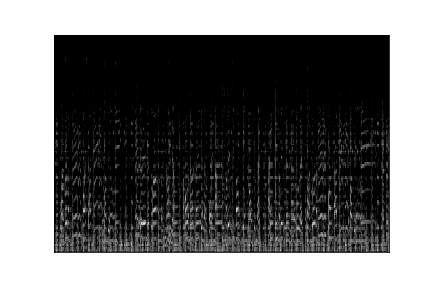

In [11]:
# Converting RGB to Grayscale
gray_test = ImageOps.grayscale(rgb_test)
gray_test

In [12]:
# Replicate single image loading/conversion to grayscale for all images
images = []
genres = []

for folder in images_folder:
    # Get files in each image-genre folder
    byte_files = subprocess.check_output(["ls", cwd + images_path + folder])
    files = byte_files.decode("utf-8").split("\n")
    files.pop(-1)
    
    for file in files:
        # Load image using its relative path as its GridFS identifier
        file_path = images_path + folder + "/" + file
        image_raw = fs.get_last_version(file_path)
        image_bytes = image_raw.read()
        rgba_image = Image.open(io.BytesIO(image_bytes))
        rgb_image = rgba_image.convert("RGB")
        gray_image = ImageOps.grayscale(rgb_image)
        image_data = np.asarray(gray_image)
        images.append(image_data)
        genres.append(folder)

In [13]:
# Convert image/genre lists to numpy arrays
images = np.asarray(images)
genres = np.asarray(genres)

# Supervised Machine Learning Models to Predict `label` from feature data

In [14]:
# Separate Features (X) from the Target (y)
y = features_3_df["label"]
X = features_3_df.drop(columns="label", axis=1)

In [15]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0             0.343065         0.086147  0.112699  0.001450   
1             0.335579         0.088129  0.143289  0.001701   
2             0.335406         0.091048  0.130405  0.003521   
3             0.363639         0.086856  0.132565  0.002448   
4             0.346815         0.092243  0.132003  0.004620   
...                ...              ...       ...       ...   
9985          0.349126         0.080515  0.050019  0.000097   
9986          0.372564         0.082626  0.057897  0.000088   
9987          0.347481         0.089019  0.052403  0.000701   
9988          0.387527         0.084815  0.066430  0.000320   
9989          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1816.693777           90525.690866              2010.051501   
1                1630.656199           79667.267654              1948.503884   
2                1773.065032          167541.630869              1972.744388   
3                1655.289045          111952.284517              1960.039988   
4                1788.539719          111407.437613              2084.565132   
...                      ...                    ...                      ...   
9985             1499.083005          164266.886443              1718.707215   
9986             1847.965128          281054.935973              1906.468492   
9987             1346.157659          662956.246325              1561.859087   
9988             2084.515327          203891.039161              2018.366254   
9989             1634.330126          411429.169769              1867.422378   

      spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
0               65671.875673   3869.682242  6.722448e+05  ...     4.074709   
1               60204.020268   3469.992864  6.102111e+05  ...     2.092937   
2              117335.771563   3714.560359  1.080790e+06  ...    -2.853603   
3               82913.639269   3568.300218  9.216524e+05  ...    -1.359111   
4               75124.921716   3997.639160  7.907127e+05  ...     4.806280   
...                      ...           ...           ...  ...          ...   
9985            85931.574523   3015.559458  8.479527e+05  ...     5.773784   
9986            99727.037054   3746.694524  1.170890e+06  ...     2.074155   
9987           138762.841945   2442.362154  2.602871e+06  ...    -1.005473   
9988            22860.992562   4313.266226  4.968878e+05  ...     4.123402   
9989           119722.211518   3462.042142  1.517016e+06  ...     1.342274   

      mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0      64.748276    -6.055294   40.677654     0.159015   51.264091   
1      30.336359     0.664582   45.880913     1.689446   51.363583   
2      39.687145    -3.241280   36.488243     0.722209   38.099152   
3      47.739452    -3.841155   28.337118     1.218588   34.770935   
4      67.336563    -1.768610   28.348579     2.378768   45.717648   
...          ...          ...         ...          ...         ...   
9985   42.485981    -9.094270   38.326839    -4.246976   31.049839   
9986   32.415203   -12.375726   66.418587    -3.081278   54.414265   
9987   78.228149    -2.524483   21.778994     4.809936   25.980829   
9988   28.323744    -5.363541   17.209942     6.462601   21.442928   
9989   38.801735   -11.598399   58.983097    -0.178517   55.761299   

      mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
0       -2.837699   97.030830     5.784063   59.943081  
1       -3.392489   26.738789     0.536961   29.146694  
2       -5.050335   33.618073    -0.243027   43.771767  
3       -3.580352   50.836224     3.630866   32.023678  
4       -1.938424   53.050835     2.517375   33.105122  
...           ...         ...          ...         ...  
9985    -5.625813   48.804092     1.818823   38.966969  
9986   -11.960546   63.452255     0.428857   18.697033

In [16]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [17]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## `RandomForestClassifier`
### `features_3_sec.csv`

In [18]:
# Instantiate the model
rf_3_model = RandomForestClassifier(n_estimators=1400, min_samples_split=2, min_samples_leaf=1,
                                  max_features="auto", max_depth=40, bootstrap=False)  # CHANGEABLE for bar plot comparisons

# Fit the model
rf_3_model = rf_3_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_3_pred = rf_3_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_3_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

Prediction  Actual
0              8       8
1              8       8
2              9       9
3              0       0
4              6       9
...          ...     ...
2493           1       1
2494           3       3
2495           2       2
2496           0       0
2497           3       3

[2498 rows x 2 columns]

In [19]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_3_pred)
cm

array([[221,   0,   4,   4,   1,   3,   3,   0,   0,   0],
       [  0, 240,   2,   0,   0,   4,   0,   0,   0,   1],
       [ 10,   2, 236,   2,   0,   7,   1,   0,   5,   0],
       [  5,   4,   4, 201,   3,   0,   1,   2,   4,   5],
       [  0,   1,   2,   9, 232,   0,   2,  10,   2,   4],
       [  5,   9,   8,   2,   0, 227,   0,   0,   0,   0],
       [  1,   0,   1,   2,   5,   0, 239,   0,   1,  10],
       [  0,   2,   9,   5,   4,   0,   0, 215,   5,   2],
       [  1,   2,   8,   2,   4,   2,   0,   7, 238,   1],
       [  7,   3,   7,  11,   0,   7,  12,   0,   5, 192]])

Text(107.5, 0.5, 'True')

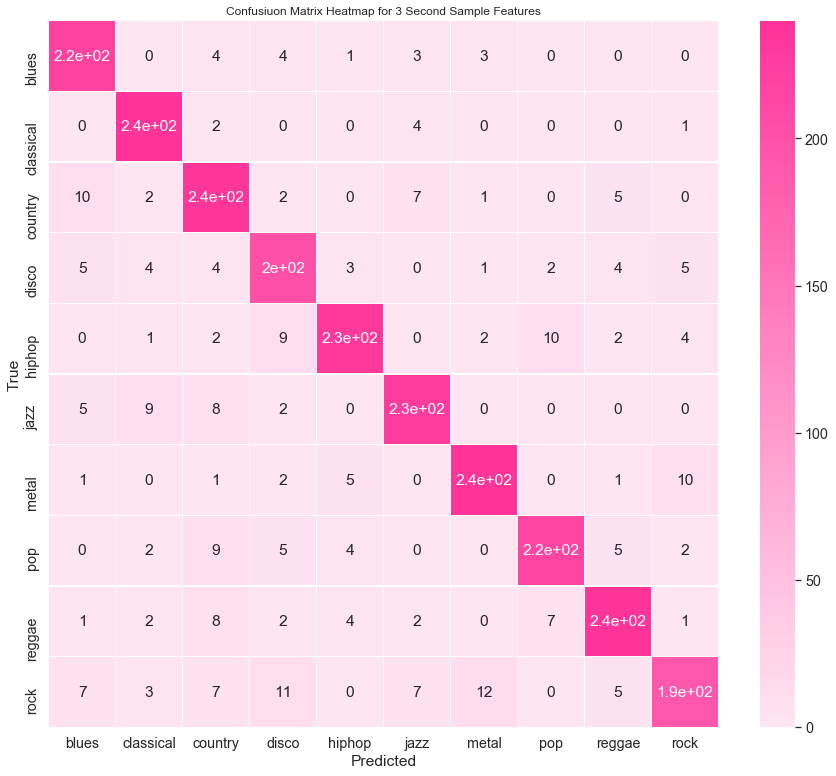

In [21]:
sortedlabels = genre_nums.keys()
cm_df = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)

sns.set(font_scale=1.3)
sns.heatmap(cm_df, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 3 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")

In [22]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_3_pred)
acc_score

0.8971176941553243

In [23]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_3_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       236
           1       0.91      0.97      0.94       247
           2       0.84      0.90      0.87       263
           3       0.84      0.88      0.86       229
           4       0.93      0.89      0.91       262
           5       0.91      0.90      0.91       251
           6       0.93      0.92      0.92       259
           7       0.92      0.89      0.90       242
           8       0.92      0.90      0.91       265
           9       0.89      0.79      0.84       244

    accuracy                           0.90      2498
   macro avg       0.90      0.90      0.90      2498
weighted avg       0.90      0.90      0.90      2498



In [24]:
classification_report_3_second = sklearn.metrics.classification_report(y_test, rf_3_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_3_second[str(i)]
total_accuracy = classification_report_3_second["accuracy"]
common_metrics = {"macro avg": classification_report_3_second["macro avg"],
                  "weighted avg": classification_report_3_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [25]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.8971176941553243


In [27]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_Metrics_3_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [28]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_3_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [29]:
# Most important features
# List in descending order by feature importance
importances = rf_3_model.feature_importances_
sorted(zip(importances, X), reverse=True)

[(0.05313858408126848, 'perceptr_var'),
 (0.03796319379244797, 'rms_var'),
 (0.03654913256115789, 'chroma_stft_mean'),
 (0.03380057802425955, 'rms_mean'),
 (0.032779540254895156, 'mfcc4_mean'),
 (0.03184314733213713, 'spectral_bandwidth_mean'),
 (0.029242517219886643, 'perceptr_mean'),
 (0.028405526056882326, 'mfcc1_mean'),
 (0.026808912262234877, 'harmony_var'),
 (0.025897576890129347, 'rolloff_mean'),
 (0.023326316960102574, 'mfcc1_var'),
 (0.022726515736156437, 'mfcc9_mean'),
 (0.022336886329051762, 'rolloff_var'),
 (0.022244265245066668, 'harmony_mean'),
 (0.02223966360693594, 'spectral_centroid_mean'),
 (0.022125099350496755, 'mfcc6_mean'),
 (0.02085286102341994, 'spectral_centroid_var'),
 (0.020359430506634583, 'mfcc3_mean'),
 (0.01923968886766487, 'zero_crossing_rate_mean'),
 (0.019194289210696047, 'mfcc8_mean'),
 (0.018324601721090548, 'mfcc5_var'),
 (0.017897523609478088, 'mfcc2_mean'),
 (0.017543434118986435, 'chroma_stft_var'),
 (0.01747453608786685, 'mfcc12_mean'),
 (0.0172

### `features_30_sec.csv`

In [30]:
# Separate Features (X) from the Target (y)
y = features_30_df["label"]
X = features_30_df.drop(columns="label", axis=1)

In [31]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0            0.350088         0.088757  0.130228  0.002827   
1            0.340914         0.094980  0.095948  0.002373   
2            0.363637         0.085275  0.175570  0.002746   
3            0.404785         0.093999  0.141093  0.006346   
4            0.308526         0.087841  0.091529  0.002303   
..                ...              ...       ...       ...   
995          0.352063         0.080487  0.079486  0.000345   
996          0.398687         0.075086  0.076458  0.000588   
997          0.432142         0.075268  0.081651  0.000322   
998          0.362485         0.091506  0.083860  0.001211   
999          0.358401         0.085884  0.054454  0.000336   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0               1784.165850          129774.064525              2002.449060   
1               1530.176679          375850.073649              2039.036516   
2               1552.811865          156467.643368              1747.702312   
3               1070.106615          184355.942417              1596.412872   
4               1835.004266          343399.939274              1748.172116   
..                      ...                    ...                      ...   
995             2008.149458          282174.689224              2106.541053   
996             2006.843354          182114.709510              2068.942009   
997             2077.526598          231657.968040              1927.293153   
998             1398.699344          240318.731073              1818.450280   
999             1609.795082          422203.216152              1797.213044   

     spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
0              85882.761315   3805.839606  9.015054e+05  ...     0.752740   
1             213843.755497   3550.522098  2.977893e+06  ...     0.927998   
2              76254.192257   3042.260232  7.840345e+05  ...     2.451690   
3             166441.494769   2184.745799  1.493194e+06  ...     0.780874   
4              88445.209036   3579.757627  1.572978e+06  ...    -4.520576   
..                      ...           ...           ...  ...          ...   
995            88609.749506   4253.557033  1.222421e+06  ...     1.789867   
996            82426.016726   4149.338328  1.046621e+06  ...     3.739020   
997            74717.124394   4031.405321  8.042154e+05  ...     1.838090   
998           109090.207161   3015.631004  1.332712e+06  ...    -2.812176   
999           120115.632927   3246.908930  1.753476e+06  ...     1.794104   

     mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
0     52.420910    -1.690215   36.524071    -0.408979   41.597103   
1     55.356403    -0.731125   60.314529     0.295073   48.120598   
2     40.598766    -7.729093   47.639427    -1.816407   52.382141   
3     44.427753    -3.319597   50.206673     0.636965   37.319130   
4     86.099236    -5.454034   75.269707    -0.916874   53.613918   
..          ...          ...         ...          ...         ...   
995   45.050526   -13.289984   41.754955     2.484145   36.778877   
996   33.851742   -10.848309   39.395096     1.881229   32.010040   
997   33.597008   -12.845291   36.367264     3.440978   36.001110   
998   46.324894    -4.416050   43.583942     1.556207   34.331261   
999   59.167755    -7.069775   73.760391     0.028346   76.504326   

     mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
0      -2.303523   55.062923     1.221291   46.936035  
1      -0.283518   51.106190     0.531217   45.786282  
2      -3.439720   46.639660    -2.231258   30.573025  
3      -0.619121   37.259739    -3.407448   31.949339  
4      -4.404827   62.910812   -11.703234   55.195160  
..           ...         ...          ...         ...  
995    -6.713265   54.866825    -1.193787   49.950665  
996    -7.461491   39.196327    -2.795338   31.773624  
997   -12.588070   42.502201    -2.106337   29.865515

In [32]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [33]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [34]:
# Instantiate the model
rf_30_model = RandomForestClassifier(n_estimators=1400, min_samples_split=2, min_samples_leaf=1,
                                  max_features="auto", max_depth=40, bootstrap=False) # CHANGEABLE for bar plot comparisons

# Fit the model
rf_30_model = rf_30_model.fit(X_train, y_train)

# Make predicitions using the testing data
rf_30_pred = rf_30_model.predict(X_test)
results = pd.DataFrame({
    "Prediction": rf_30_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

Prediction  Actual
0             9       9
1             8       8
2             2       2
3             5       5
4             6       6
..          ...     ...
245           4       4
246           9       3
247           9       0
248           4       4
249           6       6

[250 rows x 2 columns]

In [35]:
# Evaluate model
cm = sklearn.metrics.confusion_matrix(y_test, rf_30_pred)
cm

array([[16,  0,  0,  0,  0,  1,  1,  0,  1,  2],
       [ 1, 13,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 3,  0, 18,  4,  0,  2,  0,  0,  0,  3],
       [ 0,  0,  2, 13,  6,  0,  0,  0,  3,  2],
       [ 2,  0,  0,  0, 16,  0,  1,  1,  7,  1],
       [ 0,  3,  1,  1,  0, 21,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  1,  0, 24,  0,  1,  0],
       [ 0,  0,  0,  1,  1,  0,  0, 21,  1,  2],
       [ 1,  0,  0,  0,  4,  0,  0,  2, 10,  3],
       [ 2,  0,  3,  6,  1,  1,  2,  0,  0, 15]])

Text(107.5, 0.5, 'True')

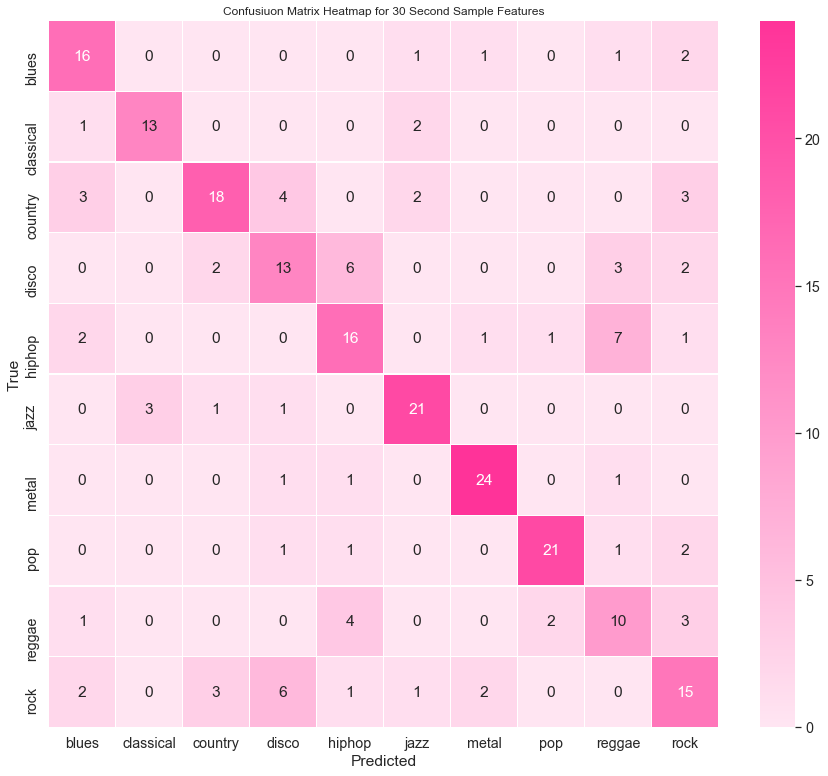

In [36]:
sortedlabels = genre_nums.keys()
cm = pd.DataFrame(cm, index=sortedlabels, columns=sortedlabels)
sns.set(font_scale=1.3)
sns.heatmap(cm, linewidths=0.5, cmap=sns.light_palette((1, 0.2, 0.6), n_colors=10000), annot=True)
sns.set(rc={"figure.figsize": (15.0, 13.0)})

plt.title("Confusiuon Matrix Heatmap for 30 Second Sample Features")
plt.xlabel("Predicted")
plt.ylabel("True")

In [37]:
# Calculate Accuracy Score
acc_score = sklearn.metrics.accuracy_score(y_test, rf_30_pred)
acc_score

0.668

In [38]:
# Print classification report
print(sklearn.metrics.classification_report(y_test, rf_30_pred))

              precision    recall  f1-score   support

           0       0.64      0.76      0.70        21
           1       0.81      0.81      0.81        16
           2       0.75      0.60      0.67        30
           3       0.50      0.50      0.50        26
           4       0.55      0.57      0.56        28
           5       0.78      0.81      0.79        26
           6       0.86      0.89      0.87        27
           7       0.88      0.81      0.84        26
           8       0.43      0.50      0.47        20
           9       0.54      0.50      0.52        30

    accuracy                           0.67       250
   macro avg       0.67      0.68      0.67       250
weighted avg       0.67      0.67      0.67       250



In [39]:
classification_report_30_second = sklearn.metrics.classification_report(y_test, rf_30_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_30_second[str(i)]
total_accuracy = classification_report_30_second["accuracy"]
common_metrics = {"macro avg": classification_report_30_second["macro avg"],
                  "weighted avg": classification_report_30_second["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

In [40]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.668


In [41]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [42]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [43]:
# Most important features
# List in descending order by feature importance
importances = rf_30_model.feature_importances_
sorted(zip(importances, X), reverse=True)

[(0.048030641789688924, 'perceptr_var'),
 (0.04566409310456823, 'chroma_stft_mean'),
 (0.03391064761277132, 'rms_mean'),
 (0.03338121723640303, 'rms_var'),
 (0.03060959893003382, 'chroma_stft_var'),
 (0.02920338985478387, 'mfcc4_mean'),
 (0.027283205343642605, 'mfcc1_mean'),
 (0.02726711795520732, 'harmony_var'),
 (0.02674511925588522, 'spectral_bandwidth_mean'),
 (0.026645172739778258, 'rolloff_mean'),
 (0.02368752669856963, 'spectral_centroid_var'),
 (0.023262252686376935, 'mfcc5_var'),
 (0.020389065228120305, 'spectral_centroid_mean'),
 (0.019703881829474263, 'rolloff_var'),
 (0.018956739016011127, 'mfcc9_mean'),
 (0.0187798713420566, 'perceptr_mean'),
 (0.018532597001924365, 'mfcc4_var'),
 (0.0183828962757156, 'mfcc20_var'),
 (0.01832631165054814, 'mfcc12_mean'),
 (0.01820929010284642, 'zero_crossing_rate_mean'),
 (0.01789979120410054, 'mfcc1_var'),
 (0.017889915821439038, 'mfcc6_mean'),
 (0.01777793833149456, 'mfcc6_var'),
 (0.017194338383797105, 'zero_crossing_rate_var'),
 (0.017

# Unsupervised Machine Learning Models to Predict `label` from feature data
## `KMeans` Cluster
### `features_3_sec.csv`

In [44]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_3_df_shuffled = features_3_df.sample(frac=1)
features_3_df_shuffled

filename  length  chroma_stft_mean  chroma_stft_var  \
287     blues.00028.7.wav   66149          0.265850         0.099289   
7847      pop.00085.5.wav   66149          0.479614         0.085916   
4518   hiphop.00052.6.wav   66149          0.427705         0.093444   
2738  country.00074.3.wav   66149          0.369261         0.084095   
4564   hiphop.00057.2.wav   66149          0.402384         0.096183   
...                   ...     ...               ...              ...   
8598   reggae.00060.6.wav   66149          0.320081         0.091266   
453     blues.00045.3.wav   66149          0.410051         0.087837   
3759    disco.00076.4.wav   66149          0.378880         0.091022   
4811   hiphop.00081.9.wav   66149          0.567875         0.074436   
3838    disco.00084.4.wav   66149          0.580416         0.069342   

      rms_mean   rms_var  spectral_centroid_mean  spectral_centroid_var  \
287   0.129895  0.002442             1345.356451           7.433387e+04   
7847  0.192071  0.002964             2744.804575           6.914154e+05   
4518  0.110105  0.001705             3121.427676           1.342270e+06   
2738  0.049563  0.000690             1478.912404           4.192568e+05   
4564  0.228050  0.003638             1868.278705           3.155829e+05   
...        ...       ...                     ...                    ...   
8598  0.022316  0.000141             2333.246184           6.841697e+05   
453   0.154581  0.000891             1661.493397           1.241755e+05   
3759  0.150355  0.002678             2192.868966           2.771967e+05   
4811  0.088115  0.003727             1506.616706           2.894496e+05   
3838  0.073121  0.002486             2301.761819           4.885316e+05   

      spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
287               1379.831446            27453.140160  ...   79.374481   
7847              2832.538226           168768.835088  ...   56.063602   
4518              3096.557189           128801.343985  ...   25.662241   
2738              1721.766055           221335.066431  ...   98.919174   
4564              2271.692141            91541.921468  ...   36.707798   
...                       ...                     ...  ...         ...   
8598              2292.773891           163252.803055  ...   42.966911   
453               2284.983084            69795.369937  ...   14.503238   
3759              2138.107863            85972.130658  ...   81.780502   
4811              1835.470644           129952.141690  ...   49.585663   
3838              2106.838690            86645.796358  ...   29.174007   

      mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
287    -13.882339   65.462257    -9.867974   24.604004    -3.540758   
7847     1.394722   68.071777     2.440068   74.615822     1.393986   
4518     3.306149   33.244621     0.213760   24.251356     0.570428   
2738   -10.672318   79.390610    -0.723974   37.228912    -9.100105   
4564    -3.096867   41.387543    -3.875971   34.980576    -4.252297   
...           ...         ...          ...         ...          ...   
8598    -9.076412   91.245544    -1.480407   50.592751    -3.497631   
453     -4.881472   33.317165    -5.647897   21.060089    -8.735706   
3759    -7.276073   28.761602     5.210104   60.148338    -4.998046   
4811     1.760175   42.426697     1.135925   30.357941     0.682467   
3838    -5.172096   30.050983    -0.254577   30.649347     1.519083   

      mfcc19_var  mfcc20_mean  mfcc20_var    label  
287    41.730690   -10.122711   47.931286    blues  
7847   71.996330     1.569460   72.850784      pop  
4518   36.066563     0.592140   47.225811   hiphop  
2738   63.152939    -8.482745   42.399105  country  
4564   38.564495    -2.510580   57.523167   hiphop  
...          ...          ...         ...      ...  
8598   45.959187   -10.411877   61.062550   reggae  
453    18.241842     1.991142   29.381048    blues  
3759   46.557915     8.825547   

In [45]:
# Separate Features (X) from the Target (y)
y = features_3_df_shuffled["label"]
X = features_3_df_shuffled.drop(columns="label", axis=1)

In [46]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
287           0.265850         0.099289  0.129895  0.002442   
7847          0.479614         0.085916  0.192071  0.002964   
4518          0.427705         0.093444  0.110105  0.001705   
2738          0.369261         0.084095  0.049563  0.000690   
4564          0.402384         0.096183  0.228050  0.003638   
...                ...              ...       ...       ...   
8598          0.320081         0.091266  0.022316  0.000141   
453           0.410051         0.087837  0.154581  0.000891   
3759          0.378880         0.091022  0.150355  0.002678   
4811          0.567875         0.074436  0.088115  0.003727   
3838          0.580416         0.069342  0.073121  0.002486   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
287              1345.356451           7.433387e+04              1379.831446   
7847             2744.804575           6.914154e+05              2832.538226   
4518             3121.427676           1.342270e+06              3096.557189   
2738             1478.912404           4.192568e+05              1721.766055   
4564             1868.278705           3.155829e+05              2271.692141   
...                      ...                    ...                      ...   
8598             2333.246184           6.841697e+05              2292.773891   
453              1661.493397           1.241755e+05              2284.983084   
3759             2192.868966           2.771967e+05              2138.107863   
4811             1506.616706           2.894496e+05              1835.470644   
3838             2301.761819           4.885316e+05              2106.838690   

      spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
287             27453.140160   2813.975548  2.561790e+05  ...    -6.817246   
7847           168768.835088   5921.630859  3.068475e+06  ...    -3.496083   
4518           128801.343985   6836.543532  2.863860e+06  ...     4.238545   
2738           221335.066431   3061.441744  1.907325e+06  ...    -6.365428   
4564            91541.921468   3971.882136  1.368306e+06  ...    -1.816554   
...                      ...           ...           ...  ...          ...   
8598           163252.803055   4766.208872  2.276692e+06  ...     3.717875   
453             69795.369937   4473.605769  9.310533e+05  ...     1.875609   
3759            85972.130658   4309.208045  1.157265e+06  ...    -1.431032   
4811           129952.141690   3078.585487  1.474600e+06  ...     1.171925   
3838            86645.796358   4616.056190  1.195249e+06  ...     5.985339   

      mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
287    79.374481   -13.882339   65.462257    -9.867974   24.604004   
7847   56.063602     1.394722   68.071777     2.440068   74.615822   
4518   25.662241     3.306149   33.244621     0.213760   24.251356   
2738   98.919174   -10.672318   79.390610    -0.723974   37.228912   
4564   36.707798    -3.096867   41.387543    -3.875971   34.980576   
...          ...          ...         ...          ...         ...   
8598   42.966911    -9.076412   91.245544    -1.480407   50.592751   
453    14.503238    -4.881472   33.317165    -5.647897   21.060089   
3759   81.780502    -7.276073   28.761602     5.210104   60.148338   
4811   49.585663     1.760175   42.426697     1.135925   30.357941   
3838   29.174007    -5.172096   30.050983    -0.254577   30.649347   

      mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
287     -3.540758   41.730690   -10.122711   47.931286  
7847     1.393986   71.996330     1.569460   72.850784  
4518     0.570428   36.066563     0.592140   47.225811  
2738    -9.100105   63.152939    -8.482745   42.399105  
4564    -4.252297   38.564495    -2.510580   57.523167  
...           ...         ...          ...         ...  
8598    -3.497631   45.959187   -10.411877   61.062550  
453     -8.735706   18.241842     1.991142   29.381048

In [47]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'blues': 0,
 'pop': 1,
 'hiphop': 2,
 'country': 3,
 'rock': 4,
 'classical': 5,
 'disco': 6,
 'reggae': 7,
 'jazz': 8,
 'metal': 9}

In [48]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

principal component 1  principal component 2  principal component 3
0               0.100974               3.982260              -0.281435
1               5.446354              -1.350222              -0.041597
2               2.927980              -1.837331              -2.657675
3               1.723902               3.365524               2.414512
4               0.657155              -0.531775              -2.547145

In [49]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 20% of variance, 2nd contains 14%, 3rd contains 10%

array([0.20054986, 0.13542712, 0.1034532 ])

In [50]:
# Initialize the K-means model
km_3_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_3_model.fit(df_pca)

# Predict clusters
predictions = km_3_model.predict(df_pca)

# Add the preicted class columns
df_pca["predicted class"] = km_3_model.labels_
df_pca["actual class"] = np.asarray(y)
df_pca

principal component 1  principal component 2  principal component 3  \
0                  0.100974               3.982260              -0.281435   
1                  5.446354              -1.350222              -0.041597   
2                  2.927980              -1.837331              -2.657675   
3                  1.723902               3.365524               2.414512   
4                  0.657155              -0.531775              -2.547145   
...                     ...                    ...                    ...   
9985               1.621635               2.252190              -0.506073   
9986              -4.462314              -1.027024              -0.686983   
9987              -2.148658              -0.723930               2.484989   
9988               1.346553               0.526454               1.294410   
9989              -0.679175              -1.584666               1.143582   

      predicted class  actual class  
0                   0             0  
1                   2             1  
2                   2             2  
3                   0             3  
4                   5             2  
...               ...           ...  
9985                5             7  
9986                1             0  
9987                9             6  
9988                9             2  
9989                9             6  

[9990 rows x 5 columns]

In [51]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [52]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

0     860
8     512
1    1903
9    1067
2     957
3    1070
4    1100
5    1099
6     463
7     959
Name: predicted class, dtype: int64

In [53]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

0    1000
8    1000
1    1000
9    1000
2     998
3     997
4     998
5     998
6     999
7    1000
Name: actual class, dtype: int64

In [54]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    for j in range(10):
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == i]["actual class"].value_counts(sort=False)[j]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df

Number of Actual 0  Number of Actual 1  Number of Actual 2  \
Predicted Class                                                               
0                               251                  10                   9   
1                               254                   0                 130   
2                                 0                 379                 244   
3                                97                   6                   5   
4                                 0                 238                  93   
5                                23                 110                  75   
6                                 0                 220                 163   
7                               121                   0                   7   
8                                85                  37                  52   
9                               169                   0                 220   

                 Number of Actual 3  Number of Actual 4  Number of Actual 5  \
Predicted Class                                                               
0                               136                  13                 199   
1                                72                 310                   0   
2                                15                  26                   0   
3                               105                  32                 571   
4                               108                 185                   9   
5                               255                 126                  14   
6                                 2                   2                   0   
7                               159                 161                 155   
8                                26                  20                  42   
9                               119                 123                   8   

                 Number of Actual 6  Number of Actual 7  Number of Actual 8  \
Predicted Class                                                               
0                                10                  53                 178   
1                               233                  27                  16   
2                                77                 207                   7   
3                                 1                   8                 243   
4                               269                  53                 121   
5                               119                 231                 143   
6                                 1                  73                   1   
7                                36                  25                 256   
8                                16                 193                  29   
9                               237                 130                   6   

                 Number of Actual 9  
Predicted Class                      
0                                 1  
1                               861  
2                                 2  
3                                 2  
4                                24  
5                                 3  
6                                 1  
7                                39  
8                                12  
9                                55

### `features_30_sec.csv`

In [55]:
# Unsupervised Machine Learning Models to Predict `label` from feature data
# K-Means Cluster Model with 10 clusters (10 known genres)
# First shuffle the rows in DataFrame so the classes are not pre-grouped
# Needed here since not using sklearn.model_selection.train_test_split (no testing data)
features_30_df_shuffled = features_30_df.sample(frac=1)
features_30_df_shuffled

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
786        pop.00086.wav  661504          0.387451         0.078213  0.132542   
500       jazz.00000.wav  661794          0.344511         0.085002  0.046747   
743        pop.00043.wav  661504          0.473502         0.080579  0.254404   
369      disco.00069.wav  661504          0.389193         0.082729  0.111631   
159  classical.00059.wav  661794          0.282641         0.082701  0.069147   
..                   ...     ...               ...              ...       ...   
823     reggae.00023.wav  661794          0.428635         0.089221  0.107873   
818     reggae.00018.wav  661794          0.394664         0.090519  0.106431   
641      metal.00041.wav  661794          0.456134         0.075901  0.097609   
255    country.00055.wav  661794          0.357053         0.084142  0.155033   
395      disco.00095.wav  661504          0.467937         0.088231  0.098458   

      rms_var  spectral_centroid_mean  spectral_centroid_var  \
786  0.001493             3593.788286           5.215268e+05   
500  0.001542             1503.869486           5.545765e+05   
743  0.004969             2702.893002           1.133988e+06   
369  0.001731             1931.082069           1.885677e+05   
159  0.001284             1551.198031           1.232696e+05   
..        ...                     ...                    ...   
823  0.002750             2354.780333           7.386638e+05   
818  0.002686             1907.516241           7.533611e+05   
641  0.000364             2269.128009           1.357942e+05   
255  0.001482             1881.299430           1.611702e+05   
395  0.002791             2486.676086           5.733349e+05   

     spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
786              3171.031491            63534.430332  ...   52.646637   
500              1754.216082           283554.933422  ...   50.311016   
743              2725.880646           228772.270841  ...   53.962646   
369              2209.150997            43228.108244  ...   29.582720   
159              1651.166213            69178.756203  ...   34.108185   
..                       ...                     ...  ...         ...   
823              2336.461430           135041.508993  ...   55.996277   
818              2124.671177           253680.252419  ...   57.486877   
641              1928.953538            88450.196573  ...   40.836742   
255              2116.203664            85092.471677  ...   46.274143   
395              2275.557079           174884.957794  ...   77.314751   

     mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  \
786     3.031741   60.295341     2.632356   68.133263     2.075720   
500    -1.503434   41.141155     0.221949   55.707256    -1.991485   
743     1.069298   42.468853     1.906279   41.177200     2.270388   
369    -7.945790   28.254889     3.666682   34.077782    -6.156417   
159    -3.483164   34.751389    -4.029826   48.350166    -7.297966   
..           ...         ...          ...         ...          ...   
823    -7.756232   54.388203     0.631764   61.935009    -4.122077   
818    -4.040069   48.546906     0.791588   51.556324    -3.755938   
641   -12.668804   40.830875    -0.556885   31.079792   -11.754225   
255    -7.598421   66.650291     5.305046   44.459827    -5.505486   
395     0.340131  115.327896     7.006258  119.066612    -5.464714   

     mfcc19_var  mfcc20_mean  mfcc20_var      label  
786   64.152771     1.358187   57.082161        pop  
500   50.006485    -3.353825   49.906403       jazz  
743   52.771935     2.421300   55.041618        pop  
369   35.428486     2.696897   33.346764      disco  
159   57.278271    -4.188187  108.393066  classical  
..          ...          ...         ...        ...  
823   67.025398     0.496620  110.006645     reggae  
818   60.003311    -1.678679   39.993298     reggae  
641   37.405830    -1.540814   30.325340      metal  
255   57.425186 

In [56]:
# Separate Features (X) from the Target (y)
y = features_30_df_shuffled["label"]
X = features_30_df_shuffled.drop(columns="label", axis=1)

In [57]:
# Drop `filename` (identifier/same as `label`) and `length` (same for all songs - 3 sec sample)
# from features X
X = X.drop(columns=["filename", "length"], axis=1)
X

chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
786          0.387451         0.078213  0.132542  0.001493   
500          0.344511         0.085002  0.046747  0.001542   
743          0.473502         0.080579  0.254404  0.004969   
369          0.389193         0.082729  0.111631  0.001731   
159          0.282641         0.082701  0.069147  0.001284   
..                ...              ...       ...       ...   
823          0.428635         0.089221  0.107873  0.002750   
818          0.394664         0.090519  0.106431  0.002686   
641          0.456134         0.075901  0.097609  0.000364   
255          0.357053         0.084142  0.155033  0.001482   
395          0.467937         0.088231  0.098458  0.002791   

     spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
786             3593.788286           5.215268e+05              3171.031491   
500             1503.869486           5.545765e+05              1754.216082   
743             2702.893002           1.133988e+06              2725.880646   
369             1931.082069           1.885677e+05              2209.150997   
159             1551.198031           1.232696e+05              1651.166213   
..                      ...                    ...                      ...   
823             2354.780333           7.386638e+05              2336.461430   
818             1907.516241           7.533611e+05              2124.671177   
641             2269.128009           1.357942e+05              1928.953538   
255             1881.299430           1.611702e+05              2116.203664   
395             2486.676086           5.733349e+05              2275.557079   

     spectral_bandwidth_var  rolloff_mean   rolloff_var  ...  mfcc16_mean  \
786            63534.430332   7634.702919  1.137355e+06  ...     3.324893   
500           283554.933422   2799.283099  2.685679e+06  ...    -1.957420   
743           228772.270841   5775.478198  3.545882e+06  ...     1.418405   
369            43228.108244   4516.110562  7.097685e+05  ...     3.481374   
159            69178.756203   2840.958923  4.381694e+05  ...    -2.880208   
..                      ...           ...           ...  ...          ...   
823           135041.508993   5050.143992  2.567123e+06  ...     9.143028   
818           253680.252419   4220.574427  3.631247e+06  ...     2.559466   
641            88450.196573   4186.459372  7.265238e+05  ...     6.971109   
255            85092.471677   4111.484522  1.124965e+06  ...     7.236835   
395           174884.957794   5007.335718  2.017482e+06  ...     5.112255   

     mfcc16_var  mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  \
786   52.646637     3.031741   60.295341     2.632356   68.133263   
500   50.311016    -1.503434   41.141155     0.221949   55.707256   
743   53.962646     1.069298   42.468853     1.906279   41.177200   
369   29.582720    -7.945790   28.254889     3.666682   34.077782   
159   34.108185    -3.483164   34.751389    -4.029826   48.350166   
..          ...          ...         ...          ...         ...   
823   55.996277    -7.756232   54.388203     0.631764   61.935009   
818   57.486877    -4.040069   48.546906     0.791588   51.556324   
641   40.836742   -12.668804   40.830875    -0.556885   31.079792   
255   46.274143    -7.598421   66.650291     5.305046   44.459827   
395   77.314751     0.340131  115.327896     7.006258  119.066612   

     mfcc19_mean  mfcc19_var  mfcc20_mean  mfcc20_var  
786     2.075720   64.152771     1.358187   57.082161  
500    -1.991485   50.006485    -3.353825   49.906403  
743     2.270388   52.771935     2.421300   55.041618  
369    -6.156417   35.428486     2.696897   33.346764  
159    -7.297966   57.278271    -4.188187  108.393066  
..           ...         ...          ...         ...  
823    -4.122077   67.025398     0.496620  110.006645  
818    -3.755938   60.003311    -1.678679   39.993298  
641   -11.754225   37.405830    -1.540814   30.325340

In [58]:
# Encode class labels in target y
genre_nums = {}
cnt = 0
for genre in y.unique():
    genre_nums[genre] = cnt
    cnt += 1

y = y.apply(lambda x: genre_nums[x])
genre_nums

{'pop': 0,
 'jazz': 1,
 'disco': 2,
 'classical': 3,
 'country': 4,
 'metal': 5,
 'reggae': 6,
 'blues': 7,
 'hiphop': 8,
 'rock': 9}

In [59]:
# Standardize features with StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Initialize PCA model with 3 principal components to visualize clusters vs. components
pca = PCA(n_components=3)

# Fit pca model to the 30 sec music feature data, X
X_pca = pca.fit_transform(X_scaled)

# Transform PCA data to a DataFrame
df_pca = pd.DataFrame(
    data=X_pca, columns=["principal component 1", "principal component 2", "principal component 3"]
)
df_pca.head()

principal component 1  principal component 2  principal component 3
0              -0.456635               3.320164              -2.054098
1               0.863094              -1.899635              -4.407010
2               1.247494               4.969291              -1.205871
3              -5.481829              -0.698183               0.218955
4              -1.422874              -3.255860              -4.752192

In [60]:
# Fetch the explained variance
pca.explained_variance_ratio_  # 1st component contains 24% of variance, 2nd contains 17%, 3rd contains 11%

array([0.23949564, 0.16929248, 0.10750028])

In [61]:
# Initialize the K-means model
km_30_model = KMeans(n_clusters=10, random_state=0)

# Fit the model
km_30_model.fit(df_pca)

# Predict clusters
predictions = km_30_model.predict(df_pca)

# Add the preicted class columns
df_pca["predicted class"] = km_30_model.labels_
df_pca["actual class"] = np.asarray(y)
df_pca

principal component 1  principal component 2  principal component 3  \
0                -0.456635               3.320164              -2.054098   
1                 0.863094              -1.899635              -4.407010   
2                 1.247494               4.969291              -1.205871   
3                -5.481829              -0.698183               0.218955   
4                -1.422874              -3.255860              -4.752192   
..                     ...                    ...                    ...   
995              -0.794894               1.044025               3.889994   
996               1.536050              -0.340568               2.453888   
997              -5.525326              -0.801238               1.214052   
998              -4.640450              -1.070540               0.862997   
999               0.570073              -0.021680               4.189831   

     predicted class  actual class  
0                  3             0  
1                  8             1  
2                  9             0  
3                  4             2  
4                  8             3  
..               ...           ...  
995                7             6  
996                1             6  
997                4             5  
998                4             4  
999                1             2  

[1000 rows x 5 columns]

In [62]:
# Plotting clusters with three features
fig = px.scatter_3d(df_pca, x="principal component 1", y="principal component 2", z="principal component 3",
                    color="predicted class", symbol="predicted class", width=800, title="Predicted Genre Clusters",
                    hover_data=["actual class"])
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [63]:
# Labels not insightful, no reason for program to label all "blues" as 0
# Check number of each prediction:
df_pca["predicted class"].value_counts(sort=False)

0     12
1     58
2    103
3    119
4    182
5    114
6     69
7    148
8    104
9     91
Name: predicted class, dtype: int64

In [64]:
# Compare to actual class breakdown
df_pca["actual class"].value_counts(sort=False)

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: actual class, dtype: int64

In [65]:
# Check number of actual class labels for a single predicted label
# Ideally we would find many of one actual class label and few of others for each predicted label, and a unique most 
# popular actual label for each predicted label
act_pred_results = np.zeros((10, 10), dtype=int)
col_names = []
for i in range(10):
    for j in range(10):
        try:
            act_pred_results[i, j] = df_pca[df_pca["predicted class"] == i]["actual class"].value_counts(sort=False)[j]
        except KeyError:
            act_pred_results[i, j] = 0
    col_names.append("Number of Actual %s" % i)

act_pred_results_df = pd.DataFrame(data=act_pred_results,
                                   columns=col_names)
act_pred_results_df.index.rename("Predicted Class", inplace=True)
act_pred_results_df

Number of Actual 0  Number of Actual 1  Number of Actual 2  \
Predicted Class                                                               
0                                 4                   3                   0   
1                                 0                   1                   5   
2                                11                   8                   7   
3                                10                  16                  31   
4                                 0                   4                  20   
5                                 2                  20                   1   
6                                33                   1                   0   
7                                 0                  10                  28   
8                                 0                  36                   0   
9                                40                   1                   8   

                 Number of Actual 3  Number of Actual 4  Number of Actual 5  \
Predicted Class                                                               
0                                 4                   0                   0   
1                                 1                   3                   1   
2                                 4                  23                   0   
3                                 1                  19                   3   
4                                 0                   6                  85   
5                                41                  16                   0   
6                                 0                   1                   0   
7                                 3                  23                  11   
8                                46                   9                   0   
9                                 0                   0                   0   

                 Number of Actual 6  Number of Actual 7  Number of Actual 8  \
Predicted Class                                                               
0                                 1                   0                   0   
1                                25                   3                  15   
2                                28                  11                   3   
3                                 8                   0                   7   
4                                 2                  24                   9   
5                                 2                  32                   0   
6                                14                   0                  19   
7                                 6                  23                  19   
8                                 2                   7                   0   
9                                12                   0                  28   

                 Number of Actual 9  
Predicted Class                      
0                                 0  
1                                 4  
2                                 8  
3                                24  
4                                32  
5                                 0  
6                                 1  
7                                25  
8                                 4  
9                                 2

# Neural Network to Predict `label` from Images

In [66]:
# Copy images and labels into new NumPy arrays
X = np.copy(images)
y = np.copy(genres)

In [67]:
# Convert categorical labels to integers 0 - 9
y = np.vectorize(genre_nums.get)(y)

In [68]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [69]:
# Normalize pixel data:
X_train = X_train / 255
X_test = X_test / 255

In [70]:
# Define Neural Net
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[288, 432]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")])

In [71]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 124416)            0         
_________________________________________________________________
dense (Dense)                (None, 300)               37325100  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
Total params: 37,376,410
Trainable params: 37,376,410
Non-trainable params: 0
____________________________________________

In [72]:
# Compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [73]:
# Train the model
history = model.fit(X_train, y_train, epochs=200)

Epoch 1/200
24/24 [==============================] - 3s 109ms/step - loss: 3.2197 - accuracy: 0.0804
Epoch 2/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3443 - accuracy: 0.0953
Epoch 3/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3257 - accuracy: 0.0982
Epoch 4/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3209 - accuracy: 0.0891
Epoch 5/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3134 - accuracy: 0.0786
Epoch 6/200
24/24 [==============================] - 3s 109ms/step - loss: 2.3143 - accuracy: 0.0900
Epoch 7/200
24/24 [==============================] - 3s 110ms/step - loss: 2.2971 - accuracy: 0.1340
Epoch 8/200
24/24 [==============================] - 3s 109ms/step - loss: 2.2947 - accuracy: 0.1255
Epoch 9/200
24/24 [==============================] - 3s 108ms/step - loss: 2.2841 - accuracy: 0.1511
Epoch 10/200
24/24 [==============================] - 3s 110ms/step - loss: 2.2835 - accura

24/24 [==============================] - 3s 115ms/step - loss: 1.8077 - accuracy: 0.3579
Epoch 82/200
24/24 [==============================] - 3s 114ms/step - loss: 1.7594 - accuracy: 0.3751
Epoch 83/200
24/24 [==============================] - 3s 109ms/step - loss: 1.8269 - accuracy: 0.3309
Epoch 84/200
24/24 [==============================] - 3s 111ms/step - loss: 1.8150 - accuracy: 0.3117
Epoch 85/200
24/24 [==============================] - 3s 110ms/step - loss: 1.8205 - accuracy: 0.3223
Epoch 86/200
24/24 [==============================] - 3s 108ms/step - loss: 1.8718 - accuracy: 0.3052
Epoch 87/200
24/24 [==============================] - 3s 111ms/step - loss: 1.7772 - accuracy: 0.3364
Epoch 88/200
24/24 [==============================] - 3s 109ms/step - loss: 1.8188 - accuracy: 0.3140
Epoch 89/200
24/24 [==============================] - 3s 111ms/step - loss: 1.7855 - accuracy: 0.3491
Epoch 90/200
24/24 [==============================] - 3s 109ms/step - loss: 1.8205 - accuracy: 

24/24 [==============================] - 3s 110ms/step - loss: 1.5474 - accuracy: 0.4345
Epoch 161/200
24/24 [==============================] - 3s 111ms/step - loss: 1.6131 - accuracy: 0.4408
Epoch 162/200
24/24 [==============================] - 3s 108ms/step - loss: 1.5167 - accuracy: 0.4461
Epoch 163/200
24/24 [==============================] - 3s 108ms/step - loss: 1.5401 - accuracy: 0.4395
Epoch 164/200
24/24 [==============================] - 3s 109ms/step - loss: 1.6168 - accuracy: 0.3792
Epoch 165/200
24/24 [==============================] - 3s 109ms/step - loss: 1.6759 - accuracy: 0.3576
Epoch 166/200
24/24 [==============================] - 3s 109ms/step - loss: 1.7231 - accuracy: 0.3638
Epoch 167/200
24/24 [==============================] - 3s 110ms/step - loss: 1.5499 - accuracy: 0.4039
Epoch 168/200
24/24 [==============================] - 3s 108ms/step - loss: 1.6492 - accuracy: 0.4112
Epoch 169/200
24/24 [==============================] - 3s 109ms/step - loss: 1.6354 - a

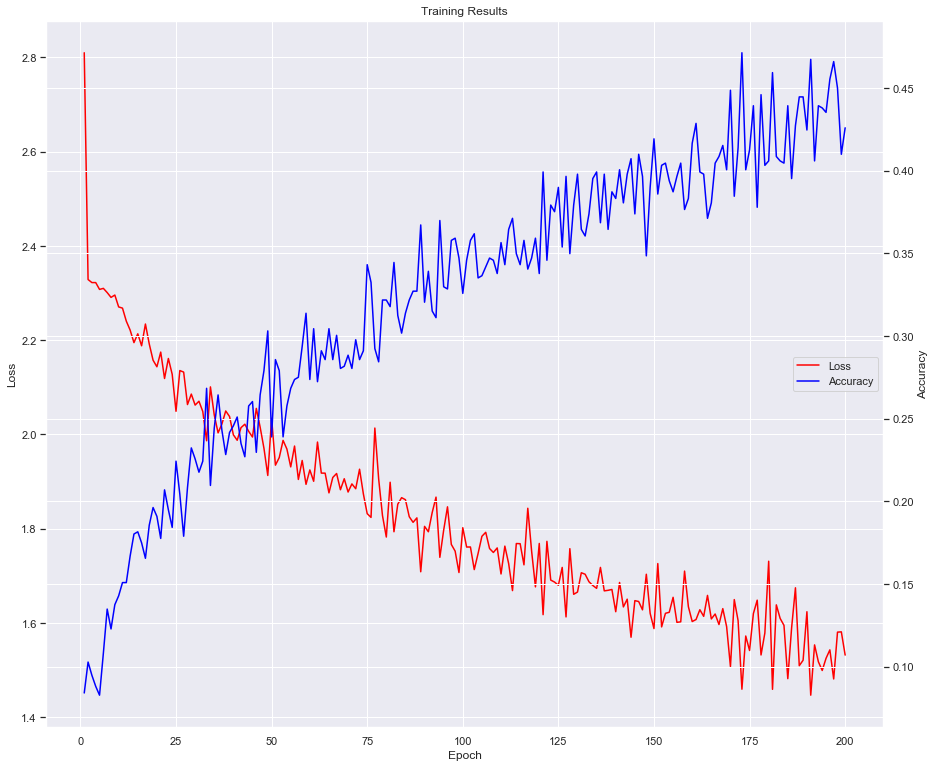

In [74]:
# Plot training results
history_df = pd.DataFrame(history.history,
                          index=range(1, len(history.history["loss"]) + 1))

fig, ax = plt.subplots()
loss = ax.plot(history_df["loss"], color="red", label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Results")

ax2 = ax.twinx()
acc = ax2.plot(history_df["accuracy"], color="blue", label="Accuracy")
ax2.set_ylabel("Accuracy")

curves = loss + acc
labs = [l.get_label() for l in curves]
ax.legend(curves, labs, loc="center right")

plt.show()

In [75]:
# Evaluate model
model.evaluate(X_test, y_test)  # Likely overfitting: 0.6 training accuracy -> 0.34 testing accuracy

8/8 [==============================] - 0s 25ms/step - loss: 2.3845 - accuracy: 0.2400


[2.3844616413116455, 0.23999999463558197]

In [88]:
nn_pred_probs = model.predict(X_test)
nn_pred = np.argmax(nn_pred_probs, axis=1)
results = pd.DataFrame({
    "Prediction": nn_pred,
    "Actual": y_test
}).reset_index(drop=True)
results

Prediction  Actual
0             1       0
1             4       7
2             7       6
3             5       5
4             7       9
..          ...     ...
245           1       6
246           7       7
247           2       8
248           7       7
249           1       9

[250 rows x 2 columns]

In [85]:
classification_report_nn = sklearn.metrics.classification_report(y_test, nn_pred, output_dict=True)
genre_metrics = {}
for i in range(10):
    genre_metrics[str(i)] = classification_report_nn[str(i)]
total_accuracy = classification_report_nn["accuracy"]
common_metrics = {"macro avg": classification_report_nn["macro avg"],
                  "weighted avg": classification_report_nn["weighted avg"]}
genre_metrics_df = pd.DataFrame.from_dict(genre_metrics)
genre_metrics_df.columns = list(genre_nums.keys())
common_metrics_df = pd.DataFrame.from_dict(common_metrics)

/opt/anaconda3/envs/PythonData/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [90]:
print("Total Accuracy:", total_accuracy)

Total Accuracy: 0.24


In [91]:
result = genre_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/Genre_metrics_nn.json", "wt")
n = text_file.write(pretty_json)
text_file.close()

In [92]:
result = common_metrics_df.to_json(orient="index")
parsed = json.loads(result) 
pretty_json = json.dumps(parsed, indent=4)
text_file = open(cwd + "Post_Analysis_Data/common_metrics_30_Sec.json", "wt")
n = text_file.write(pretty_json)
text_file.close()